<a href="https://colab.research.google.com/github/gowthambalachandhiran/VisualQuestionAnswering/blob/master/VisualQuestioningNewModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Welcome to Colaboratory!</h1>


Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud.

With Colaboratory you can write and execute code, save and share your analyses, and access powerful computing resources, all for free from your browser.

In [0]:
#@title Introducing Colaboratory { display-mode: "form" }
#@markdown This 3-minute video gives an overview of the key features of Colaboratory:
from IPython.display import YouTubeVideo
YouTubeVideo('inN8seMm7UI', width=600, height=400)

## Getting Started

The document you are reading is a  [Jupyter notebook](https://jupyter.org/), hosted in Colaboratory. It is not a static page, but an interactive environment that lets you write and execute code in Python and other languages.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [0]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter".

All cells modify the same global state, so variables that you define by executing a cell can be used in other cells:

In [0]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

For more information about working with Colaboratory notebooks, see [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb).


## More Resources

Learn how to make the most of Python, Jupyter, Colaboratory, and related tools with these resources:

### Working with Notebooks in Colaboratory
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>
 [TensorFlow 2 in Colab](/notebooks/tensorflow_version.ipynb)

### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb)
- [Tensorflow concepts](/notebooks/mlcc/tensorflow_programming_concepts.ipynb)
- [First steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)
- [Intro to neural nets](/notebooks/mlcc/intro_to_neural_nets.ipynb)
- [Intro to sparse data and embeddings](/notebooks/mlcc/intro_to_sparse_data_and_embeddings.ipynb)

### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

## Machine Learning Examples: Seedbank

To see end-to-end examples of the interactive machine learning analyses that Colaboratory makes possible, check out the [Seedbank](https://research.google.com/seedbank/) project.

A few featured examples:

- [Neural Style Transfer](https://research.google.com/seedbank/seed/neural_style_transfer_with_tfkeras): Use deep learning to transfer style between images.
- [EZ NSynth](https://research.google.com/seedbank/seed/ez_nsynth): Synthesize audio with WaveNet auto-encoders.
- [Fashion MNIST with Keras and TPUs](https://research.google.com/seedbank/seed/fashion_mnist_with_keras_and_tpus): Classify fashion-related images with deep learning.
- [DeepDream](https://research.google.com/seedbank/seed/deepdream): Produce DeepDream images from your own photos.
- [Convolutional VAE](https://research.google.com/seedbank/seed/convolutional_vae): Create a generative model of handwritten digits.

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os, argparse
import cv2, spacy, numpy as np
from keras.layers import Input, LSTM, Embedding, Dense
from keras.applications.vgg16 import VGG16
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras import backend as K
from keras.utils.vis_utils import plot_model
K.set_image_data_format('channels_first')
import csv

In [21]:
pip install keras==1.1

     |████████████████████████████████| 153kB 2.8MB/s 
  Created wheel for keras: filename=Keras-1.1.0-cp36-none-any.whl size=178686 sha256=ba4209375a49a91cf8bcee572de5ca61409c6156c756d90381b285a3c69c8e89
  Stored in directory: /root/.cache/pip/wheels/ae/83/3e/c42ce0672e537640ee706143ebdd1dd691b7693b4ca50f72a8
Successfully built keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 1.1.0 which is incompatible.
ERROR: kapre 0.1.3.1 has requirement keras>=2.0.0, but you'll have keras 1.1.0 which is incompatible.
ERROR: fancyimpute 0.4.3 has requirement keras>=2.0.0, but you'll have keras 1.1.0 which is incompatible.
  Found existing installation: Keras 2.1.1
    Uninstalling Keras-2.1.1:
      Successfully uninstalled Keras-2.1.1


In [0]:
nlp = spacy.load("en")

In [0]:
def get_image_model_without():
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    image_model = VGG16(weights='imagenet', include_top=False)
    image_model.layers.pop()
    image_model.layers.pop()
    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

In [0]:
def get_image_model(CNN_weights_file_name):
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    from models.CNN.VGG import VGG_16
    image_model = VGG_16("models/CNN/vgg16_weights.h5")
    image_model.layers.pop()
    image_model.layers.pop()
    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

In [0]:
vgg_without = get_image_model_without()

In [0]:
def get_question_features_without_fd(question):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    word_embeddings = spacy.load('en')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((30, 300))
    for j in range(len(tokens)):
        question_tensor[j,:] = tokens[j].vector
    return question_tensor

In [0]:
def get_image_features_without_fd(image_file_name):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    image_features = np.zeros((4096))
    # Magic_Number = 4096  > Comes from last layer of VGG Model

    # Since VGG was trained as a image of 224x224, every new image
    # is required to go through the same transformation
    im = cv2.resize(cv2.imread(image_file_name), (224, 224))
    im = im.transpose((2,0,1)) # convert the image to RGBA

    
    # this axis dimension is required because VGG was trained on a dimension
    # of 1, 3, 224, 224 (first axis is for the batch size
    # even though we are using only one image, we have to keep the dimensions consistent
    im = np.expand_dims(im, axis=0) 

    image_features[:] = vgg_without.predict(im)[0]
    return image_features

In [0]:
def get_VQA_model():
    ''' Given the VQA model and its weights, compiles and returns the model '''

    # thanks the keras function for loading a model from JSON, this becomes
    # very easy to understand and work. Alternative would be to load model
    # from binary like cPickle but then model would be obfuscated to users
    vqa_model = model_from_json(open("/content/Model/our_model.json").read())
    # vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [0]:
batch_size               =      512
img_dim                  =     4096
word2vec_dim             =      300
num_hidden_nodes_mlp     =     1024
num_hidden_nodes_lstm    =      512
num_layers_lstm          =        3
dropout                  =       0.5
activation_mlp           =     'tanh'
num_epochs = 5

In [96]:
image_model = Sequential()
image_model.add(Reshape(input_shape = (4096,), target_shape=(4096,)))
model1 = Model(inputs = image_model.input, outputs = image_model.output)
model1.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13_input (InputLayer (None, 4096)              0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 4096)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [97]:
language_model = Sequential()
language_model.add(LSTM(output_dim=num_hidden_nodes_lstm, 
                        return_sequences=True, input_shape=(None, word2vec_dim)))

for i in range(num_layers_lstm-2):
    language_model.add(LSTM(output_dim=num_hidden_nodes_lstm, return_sequences=True))
language_model.add(LSTM(output_dim=num_hidden_nodes_lstm, return_sequences=False))

model2 = Model(language_model.input, language_model.output)
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2_input (InputLayer)    (None, None, 300)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 512)         1665024   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 512)               2099200   
Total params: 5,863,424
Trainable params: 5,863,424
Non-trainable params: 0
_________________________________________________________________


In [0]:
combined = concatenate([image_model.output, language_model.output])

In [0]:
upper_lim = 10
model = Dense(num_hidden_nodes_mlp, init='uniform', activation = 'tanh')(combined)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(num_hidden_nodes_mlp, init='uniform', activation = 'tanh')(model)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(num_hidden_nodes_mlp, init='uniform', activation = 'tanh')(model)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(upper_lim)(model)
model = Activation("softmax")(model)

model = Model(inputs=[image_model.input, language_model.input], outputs=model)

In [104]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_2_input (InputLayer)       (None, None, 300)    0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 512)    1665024     lstm_2_input[0][0]               
__________________________________________________________________________________________________
reshape_13_input (InputLayer)   (None, 4096)         0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, None, 512)    2099200     lstm_2[0][0]                     
____________________________________________________________________________________________

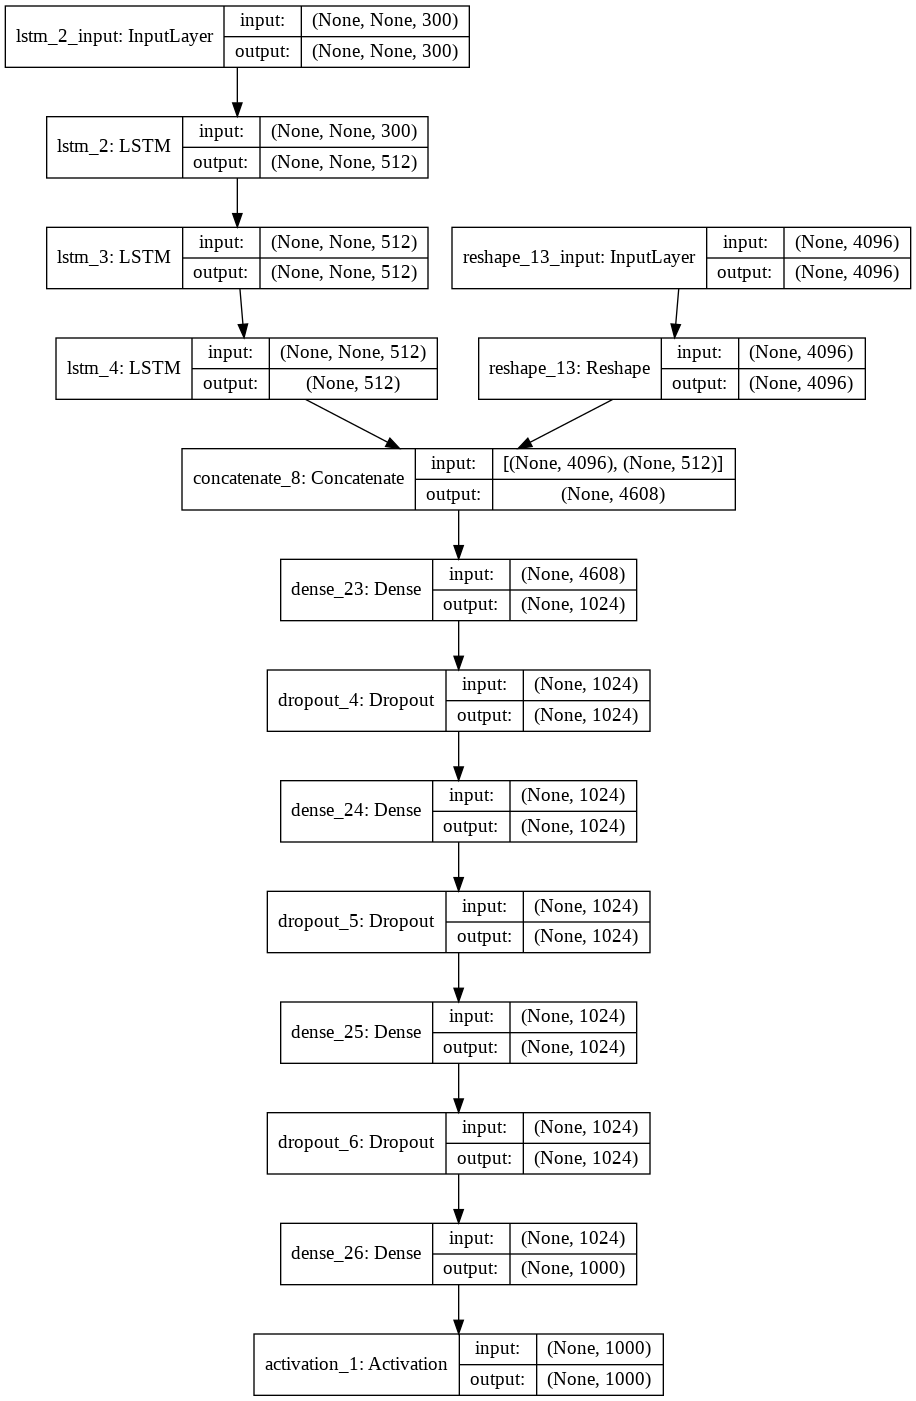

In [102]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
from keras.models import model_from_json

In [0]:
model_json = model.to_json()
with open("/content/Model/our_model_new.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
def get_VQA_model():
    ''' Given the VQA model and its weights, compiles and returns the model '''

    # thanks the keras function for loading a model from JSON, this becomes
    # very easy to understand and work. Alternative would be to load model
    # from binary like cPickle but then model would be obfuscated to users
    vqa_model = model_from_json(open("/content/Model/our_model_new.json").read())
    # vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [109]:
our_vqa_model = get_VQA_model()
our_vqa_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_2_input (InputLayer)       (None, None, 300)    0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 512)    1665024     lstm_2_input[0][0]               
__________________________________________________________________________________________________
reshape_13_input (InputLayer)   (None, 4096)         0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, None, 512)    2099200     lstm_2[0][0]                     
____________________________________________________________________________________________